## Quick validation of network modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import utils, paths

np.random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
# Params to examine module size
clustering_method_list = ["dbscan", "hierarchal", "affinity", "louvain", "infomap"]

# Params for regulon/operon coverage
# Clustering method to examine regulon/operon coverage
# This method needs to be one of the ones listed above in `clustering_method_list`
method_toexamine = "affinity"

# Remove modules of this size or greater for analysis looking at coverage of regulon/operons
module_size_threshold = 1000

# Seed to use to randomly sample a matched-sized set of genes
# to compare against regulon/operon composition
sample_seed = 1

## Examine size of modules

This will serve as a quick check that we are using reasonable clustering params in [2_get_network_communities.ipynb](2_get_network_communities.ipynb)

In [3]:
for method_name in clustering_method_list:
    print(f"Modules using clustering method: {method_name}")
    pao1_membership_filename = os.path.join(
        paths.LOCAL_DATA_DIR, f"pao1_modules_{method_name}.tsv"
    )
    pa14_membership_filename = os.path.join(
        paths.LOCAL_DATA_DIR, f"pa14_modules_{method_name}.tsv"
    )

    pao1_membership = pd.read_csv(
        pao1_membership_filename, sep="\t", header=0, index_col=0
    )
    pa14_membership = pd.read_csv(
        pa14_membership_filename, sep="\t", header=0, index_col=0
    )
    # Note: Sort module ids by occurence for plotting later
    pao1_membership.sort_values(by="module id", ascending=False, inplace=True)
    pa14_membership.sort_values(by="module id", ascending=False, inplace=True)

    print(pao1_membership["module id"].value_counts())
    print(pa14_membership["module id"].value_counts())

Modules using clustering method: dbscan
 0     2874
-1     2371
 6       37
 19      23
 18      21
 17      19
 10      14
 23      13
 25      13
 11      12
 14      11
 3       10
 8        9
 1        9
 20       8
 22       8
 32       7
 26       7
 4        6
 21       6
 9        5
 16       5
 12       5
 36       5
 35       5
 13       5
 29       5
 31       5
 2        5
 30       5
 34       5
 15       5
 27       5
 33       5
 5        4
 28       4
 24       4
 7        3
Name: module id, dtype: int64
-1     3152
 0     2225
 2       45
 3       38
 21      31
 34      25
 5       20
 9       17
 4       16
 23      15
 43      14
 44      14
 42      14
 25      13
 26      13
 6       13
 13      12
 12      12
 35      11
 32       9
 7        9
 41       9
 8        9
 31       8
 1        8
 20       8
 40       7
 16       7
 45       7
 18       7
 22       7
 39       6
 17       6
 10       6
 19       6
 15       6
 38       5
 46       5
 11       5
 24   

In [4]:
# plotting function
def plot_dist_modules(clustering_method_list):

    # Set up the matplotlib figure
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(len(clustering_method_list)):
        pao1_membership_filename = os.path.join(
            paths.LOCAL_DATA_DIR, f"pao1_modules_{clustering_method_list[i]}.tsv"
        )
        pa14_membership_filename = os.path.join(
            paths.LOCAL_DATA_DIR, f"pa14_modules_{clustering_method_list[i]}.tsv"
        )

        pao1_membership = pd.read_csv(
            pao1_membership_filename, sep="\t", header=0, index_col=0
        )
        pa14_membership = pd.read_csv(
            pa14_membership_filename, sep="\t", header=0, index_col=0
        )

        fig = (
            pao1_membership["module id"]
            .value_counts()
            .sort_values(ascending=False)
            .reset_index()["module id"]
            .plot(ax=axes[i])
        )
        fig = (
            pa14_membership["module id"]
            .value_counts()
            .sort_values(ascending=False)
            .reset_index()["module id"]
            .plot(ax=axes[i])
        )

        fig.set_title(
            f"Histogram of size of modules using {clustering_method_list[i]}",
            fontsize=12,
        )
        handles, labels = fig.get_legend_handles_labels()
        fig.legend(handles, ["PAO1", "PA14"], loc="upper right")

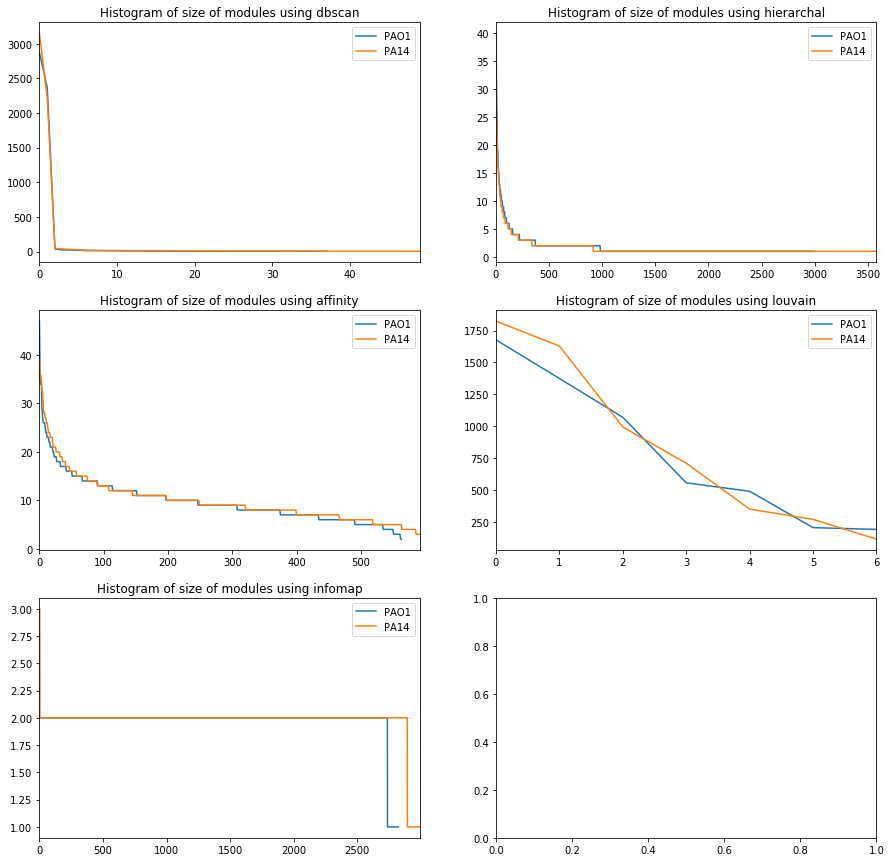

In [5]:
# Plot distribution of modules per clustering method
plot_dist_modules(clustering_method_list)

**Takeaway:**
Our expectation on size of modules would be 2-50 genes. Most operons have fewer than 10 genes and most regulons have fewer than 100 genes. Some examples that demonstrate the size of co-expression networks can be found in papers using ADAGE signatures to define modules:
* Figure 5 in [eADAGE paper](https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/s12859-017-1905-4.pdf)
* Figure 7 in [Harty et al. paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6531624/)
* Figure 2 in [Doing et al. paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008783)

What did we find? Which method follows our expectation? This is the one we will move forward.
* Looks like there is one large modules using DBSCAN clustering
* There are more even sized modules using hierarchal clustering and affinity propogation so we will probably use one of these 2 methods.

## Examine composition of modules

This is a negative control. We expect that genes within the same operon or regulon will cluster together (i.e. be within the same module). To test this we will compare the distribution of the number of modules that contain genes within the same regulon vs the number of modules that contain random genes

_Some definitions:_

[Operons](https://en.wikipedia.org/wiki/Operon#:~:text=An%20operon%20is%20made%20up,transcription%20of%20the%20structural%20genes.) are a group of genes that share a promoter (DNA sequence that is recognized by RNA polymerase and enables transcription) and an operator (DNA sequence that repressor binds to and blocks RNA polymerase). Therefore these group of genes are transcribed or turned off together (so we would expect a very high correlation amongst these genes)

[Regulons](https://en.wikipedia.org/wiki/Regulon) are a group of genes that are regulated by the same regulatory protein. A regulon can be composed of multiple operons.

In [6]:
# Load PAO1 regulon and operon file
pao1_regulon_filename = paths.PAO1_REGULON
pao1_operon_filename = paths.PAO1_OPERON

# Load membership for specific clustering method
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_modules_{method_toexamine}.tsv"
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_modules_{method_toexamine}.tsv"
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", header=0, index_col=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", header=0, index_col=0)

In [7]:
pao1_membership.head()

,module id
PA0001,390
PA0002,0
PA0003,491
PA0004,298
PA0005,522


In [8]:
pa14_membership.head()

,module id
PA14_55610,425
PA14_55600,168
PA14_55590,425
PA14_55580,379
PA14_55570,189


According to Jake relationships tend to be more meaningful if the module is smaller (e.g. if an operon with 5 genes is contained in a module consisting of 10 total genes, this seems more biologically/functionally meaningful than an operon with 5 genes contained in a module consisting of 500 genes).

To correct for the single or couple very large modules, we will remove them from the analysis

In [9]:
# Get module ids that exceed size limit
module_todrop = (
    pao1_membership["module id"]
    .value_counts()[
        (pao1_membership["module id"].value_counts() > module_size_threshold)
    ]
    .index
)

print(module_todrop)

Int64Index([], dtype='int64')


In [10]:
# Get genes to drop
genes_todrop = pao1_membership[pao1_membership["module id"].isin(module_todrop)].index

# Drop genes
pao1_membership = pao1_membership.drop(genes_todrop)

### Format operon/regulon files

* Remove genes from operons/regulons that don't have membership information
* Make random list of genes with matched size
* There are many single gene operons, we will remove these for this analysis

In [11]:
# Read file
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
pao1_regulon = pd.read_csv(pao1_regulon_filename, index_col=0, header=0)

print(pao1_operon.shape)
pao1_operon.head()

(3257, 2)


,Length,Genes
OperonID,,
12029,4,PA0001;PA0002;PA0003;PA0004
12030,2,PA0005;PA0006
12031,2,PA0008;PA0009
12032,3,PA0016;PA0017;PA0018
12033,2,PA0021;PA0022


In [12]:
print(pao1_regulon.shape)
pao1_regulon.head()

(17, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,PA5475;PA1673;PA5027;PA3337;PA4348;PA4347;PA43...
PhoB_regulon,160,PA0050;PA0051;PA0082;PA0102;PA0105;PA0165;PA01...
PvdR_regulon,14,PA2386;PA2399;PA2397;PA2396;PA2425;PA2413;PA24...
PchR_regulon,12,PA4231;PA4230;PA4229;PA4228;PA4226;PA4225;PA42...
AlgU_regulon,238,PA0059;PA0060;PA0061;PA0062;PA0071;PA0134;PA01...


In [13]:
# Convert "Genes" column from str to list
pao1_operon["Genes"] = pao1_operon["Genes"].str.split(";")
pao1_regulon["Genes"] = pao1_regulon["Genes"].str.split(";")

In [14]:
# Check if genes within operon/regulon have membership information
# Only keep genes that are found in "pao1_membership"
pao1_operon["Genes_processed"] = pao1_operon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)
pao1_regulon["Genes_processed"] = pao1_regulon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)

In [15]:
# Update length based on filtered gene list ("Genes_processed" column)
pao1_operon["Length_processed"] = pao1_operon["Genes_processed"].str.len()
pao1_regulon["Length_processed"] = pao1_regulon["Genes_processed"].str.len()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of size of operons/regulons after filtering by membership')

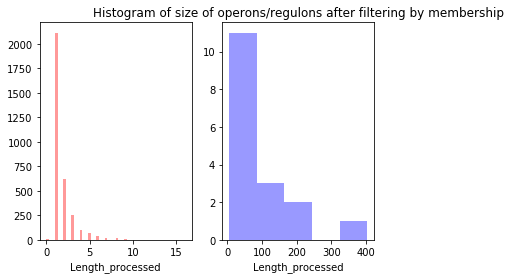

In [16]:
# Quick look at distribution of size of regulons and operons
# Update length based on filtered gene list ("Genes_processed" column)

fig, axes = plt.subplots(ncols=2, nrows=1)

fig = sns.distplot(
    pao1_operon["Length_processed"],
    label="PAO1 operon size",
    color="red",
    kde=False,
    ax=axes[0],
)

fig = sns.distplot(
    pao1_regulon["Length_processed"],
    label="PAO1 regulon size",
    color="blue",
    kde=False,
    ax=axes[1],
)

fig.set_title(
    "Histogram of size of operons/regulons after filtering by membership",
    fontsize=12,
)

In [17]:
# If number genes in operon are 1 then remove
# Drop operons and regulons that have 0 genes due to no module filtering
pao1_operon = pao1_operon.drop(pao1_operon.query("Length_processed<=1").index)
pao1_regulon = pao1_regulon.drop(pao1_regulon.query("Length_processed<=1").index)

print(pao1_operon.shape)
print(pao1_regulon.shape)

(1139, 4)
(17, 4)


In [18]:
# For each regulon/operon, select a random set of genes that are the same size at the regulon/operon
pao1_operon["Random_Genes"] = pao1_operon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(
        num_genes, random_state=sample_seed
    ).index.values
)
pao1_regulon["Random_Genes"] = pao1_regulon["Length_processed"].apply(
    lambda num_genes: pao1_membership.sample(
        num_genes, random_state=sample_seed
    ).index.values
)

In [19]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes
OperonID,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]"
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA2343, PA0361]"
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA2343, PA0361]"
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA2343, PA0361, PA5405]"
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA2343, PA0361]"


In [20]:
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes
Regulon,,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022..."
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022..."
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022..."
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022..."


### Get operon/regulon information using PA14 ids

In [21]:
pa14_operon = pao1_operon.copy()
pa14_regulon = pao1_regulon.copy()

In [22]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")
gene_mapping_pao1.head()

,Name,Product.Name,GeneID.(PAO1),PA14_ID,annotation,num_mapped_genes
PAO1_ID,,,,,,
PA0001,dnaA,chromosomal replication initiator protein DnaA,878417.0,PA14_00010,core,1.0
PA0002,dnaN,"DNA polymerase III, beta chain",879244.0,PA14_00020,core,1.0
PA0003,recF,RecF protein,879229.0,PA14_00030,core,1.0
PA0004,gyrB,DNA gyrase subunit B,879230.0,PA14_00050,core,1.0
PA0005,lptA,"lysophosphatidic acid acyltransferase, LptA",877576.0,PA14_00060,core,1.0


In [23]:
pa14_operon["Genes_processed"] = pa14_operon["Genes_processed"].apply(
    lambda pao1_gene_list: gene_mapping_pao1.loc[pao1_gene_list, "PA14_ID"].values
)
pa14_regulon["Genes_processed"] = pa14_regulon["Genes_processed"].apply(
    lambda pao1_gene_list: gene_mapping_pao1.loc[pao1_gene_list, "PA14_ID"].values
)

In [24]:
# Update length based on filtered gene list ("Genes_processed" column)
pa14_operon["Length_processed"] = pa14_operon["Genes_processed"].str.len()
pa14_regulon["Length_processed"] = pa14_regulon["Genes_processed"].str.len()

In [25]:
# If genes didn't map then drop operon/regulon
pa14_operon = pa14_operon.drop(
    pa14_operon[
        pa14_operon["Genes_processed"].apply(lambda gene_list: pd.isna(gene_list).any())
    ].index
)
pa14_regulon = pa14_regulon.drop(
    pa14_regulon[
        pa14_regulon["Genes_processed"].apply(
            lambda gene_list: pd.isna(gene_list).any()
        )
    ].index
)

print(pa14_operon.shape)
print(pa14_regulon.shape)

(1085, 5)
(12, 5)


In [26]:
# If number genes in operon are 1 then remove
# Drop operons and regulons that have 0 genes due to no module filtering
pa14_operon = pa14_operon.drop(pa14_operon.query("Length_processed<=1").index)
pa14_regulon = pa14_regulon.drop(pa14_regulon.query("Length_processed<=1").index)

print(pa14_operon.shape)
print(pa14_regulon.shape)

(1085, 5)
(12, 5)


In [27]:
# For each regulon/operon, select a random set of genes that are the same size at the regulon/operon
pa14_operon["Random_Genes"] = pa14_operon["Length_processed"].apply(
    lambda num_genes: pa14_membership.sample(num_genes).index.values
)
pa14_regulon["Random_Genes"] = pa14_regulon["Length_processed"].apply(
    lambda num_genes: pa14_membership.sample(num_genes).index.values
)

In [28]:
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes
OperonID,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]"
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA2343, PA0361]"
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA2343, PA0361]"
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA2343, PA0361, PA5405]"
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA2343, PA0361]"


In [29]:
pa14_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes
OperonID,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA14_00010, PA14_00020, PA14_00030, PA14_00050]",4,"[PA14_39945, PA14_18890, PA14_17150, PA14_69390]"
12030,2,"[PA0005, PA0006]","[PA14_00060, PA14_00070]",2,"[PA14_35520, PA14_56360]"
12031,2,"[PA0008, PA0009]","[PA14_00090, PA14_00100]",2,"[PA14_13500, PA14_66830]"
12032,3,"[PA0016, PA0017, PA0018]","[PA14_00170, PA14_00180, PA14_00190]",3,"[PA14_71820, PA14_57210, PA14_15150]"
12033,2,"[PA0021, PA0022]","[PA14_00230, PA14_00240]",2,"[PA14_70080, PA14_07150]"


### Calculate the distribution

In [30]:
# For each regulon/operon get the number of modules that regulon/operon genes are found in, number of modules
# that random genes are found in
pao1_operon["Num_operon_modules"] = pao1_operon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_operon["Num_random_modules"] = pao1_operon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [31]:
# For PA14
pa14_operon["Num_operon_modules"] = pa14_operon["Genes_processed"].apply(
    lambda list_genes: pa14_membership.loc[list_genes]["module id"].nunique()
)
pa14_operon["Num_random_modules"] = pa14_operon["Random_Genes"].apply(
    lambda list_genes: pa14_membership.loc[list_genes]["module id"].nunique()
)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# For PAO1 regulons
pao1_regulon["Num_regulon_modules"] = pao1_regulon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)
pao1_regulon["Num_random_modules"] = pao1_regulon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

In [33]:
# For PA14 regulons
pa14_regulon["Num_regulon_modules"] = pa14_regulon["Genes_processed"].apply(
    lambda list_genes: pa14_membership.loc[list_genes]["module id"].nunique()
)
pa14_regulon["Num_random_modules"] = pa14_regulon["Random_Genes"].apply(
    lambda list_genes: pa14_membership.loc[list_genes]["module id"].nunique()
)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
print(pao1_operon.shape)
pao1_operon.head()

(1139, 7)


,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules
OperonID,,,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]",4,4
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA2343, PA0361]",2,2
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA2343, PA0361]",2,2
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA2343, PA0361, PA5405]",1,3
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA2343, PA0361]",2,2


In [35]:
print(pa14_operon.shape)
pa14_operon.head()

(1085, 7)


,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules
OperonID,,,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA14_00010, PA14_00020, PA14_00030, PA14_00050]",4,"[PA14_39945, PA14_18890, PA14_17150, PA14_69390]",2,4
12030,2,"[PA0005, PA0006]","[PA14_00060, PA14_00070]",2,"[PA14_35520, PA14_56360]",2,2
12031,2,"[PA0008, PA0009]","[PA14_00090, PA14_00100]",2,"[PA14_13500, PA14_66830]",1,2
12032,3,"[PA0016, PA0017, PA0018]","[PA14_00170, PA14_00180, PA14_00190]",3,"[PA14_71820, PA14_57210, PA14_15150]",2,3
12033,2,"[PA0021, PA0022]","[PA14_00230, PA14_00240]",2,"[PA14_70080, PA14_07150]",2,2


In [36]:
print(pao1_regulon.shape)
pao1_regulon.head()

(17, 7)


,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules
Regulon,,,,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",23,69
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",114,139
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",2,14
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",2,12
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",110,185


In [37]:
print(pa14_regulon.shape)
pa14_regulon.head()

(12, 7)


,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules
Regulon,,,,,,,
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA14_00630, PA14_00640, PA14_00990, PA14_0124...",160,"[PA14_25640, PA14_70650, PA14_02580, PA14_5050...",110,141
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA14_33810, PA14_33650, PA14_33690, PA14_3370...",14,"[PA14_00410, PA14_01180, PA14_27520, PA14_3428...",1,14
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA14_09210, PA14_09220, PA14_09230, PA14_0924...",12,"[PA14_11830, PA14_07810, PA14_47810, PA14_3821...",1,12
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA14_00710, PA14_00720, PA14_00730, PA14_0074...",228,"[PA14_50920, PA14_53940, PA14_05590, PA14_5896...",97,188
PqsR_regulon,133,"[PA0122, PA0355, PA0567, PA0996, PA0997, PA099...","[PA14_01490, PA14_04650, PA14_07370, PA14_5143...",130,"[PA14_12680, PA14_22180, PA14_30590, PA14_3655...",62,116


In [38]:
# Format df for plotting using displot
pao1_operon_toplot = pd.melt(
    pao1_operon, value_vars=["Num_operon_modules", "Num_random_modules"]
)
pao1_regulon_toplot = pd.melt(
    pao1_regulon, value_vars=["Num_regulon_modules", "Num_random_modules"]
)

pao1_operon_toplot.tail()

,variable,value
2273,Num_random_modules,2
2274,Num_random_modules,9
2275,Num_random_modules,4
2276,Num_random_modules,2
2277,Num_random_modules,2


In [39]:
pa14_operon_toplot = pd.melt(
    pa14_operon, value_vars=["Num_operon_modules", "Num_random_modules"]
)
pa14_regulon_toplot = pd.melt(
    pa14_regulon, value_vars=["Num_regulon_modules", "Num_random_modules"]
)

pa14_operon_toplot.tail()

,variable,value
2165,Num_random_modules,2
2166,Num_random_modules,2
2167,Num_random_modules,9
2168,Num_random_modules,4
2169,Num_random_modules,2


In [40]:
def cumulative_distribution(
    data,
    scaled=False,
    survival=False,
    label="Cumulative",
    fill=False,
    flip=False,
    preserve_ends=0,
    **kwargs,
):
    """
    plots cumulative (or survival) step distribution
    adapted from https://github.com/MarvinT/morphs/blob/master/morphs/plot/utils.py
    """
    data = np.sort(data)
    if survival:
        data = data[::-1]
    y = np.arange(data.size + 1, dtype=float)
    if scaled:
        y /= y[-1]
    x = np.concatenate([data, data[[-1]]])
    plt.step(x, y, label=label, **kwargs)
    if fill:
        plt.fill_between(x, y, alpha=0.5, step="pre", **kwargs)

Ks_2sampResult(statistic=0.3942054433713784, pvalue=4.2345824903091397e-78)

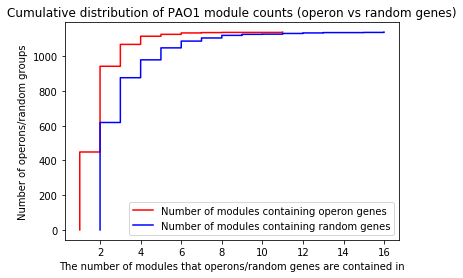

In [41]:
cumulative_distribution(
    pao1_operon["Num_operon_modules"],
    label="Number of modules containing operon genes",
    color="red",
)
cumulative_distribution(
    pao1_operon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of PAO1 module counts (operon vs random genes)")
plt.ylabel("Number of operons/random groups")
plt.xlabel("The number of modules that operons/random genes are contained in")

scipy.stats.ks_2samp(
    pao1_operon["Num_operon_modules"], pao1_operon["Num_random_modules"]
)

Text(0.5, 1.0, 'PMF distribution of module counts (operon vs random genes)')

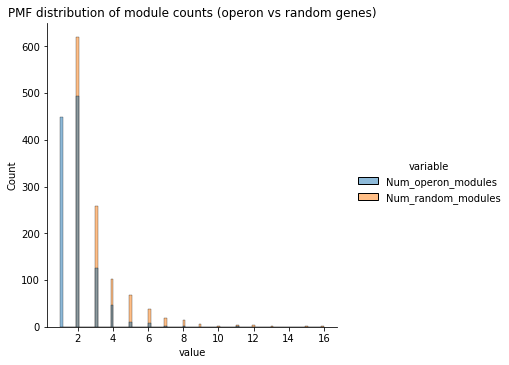

In [42]:
fig = sns.displot(
    pao1_operon_toplot,
    x="value",
    hue="variable",
)
plt.title("PMF distribution of module counts (operon vs random genes)")

Ks_2sampResult(statistic=0.3880184331797235, pvalue=3.9327723329397883e-72)

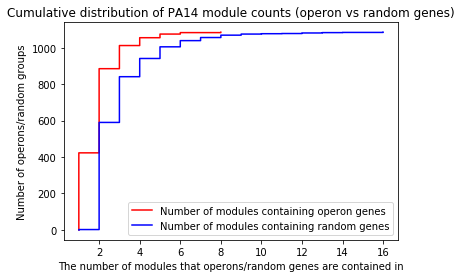

In [43]:
cumulative_distribution(
    pa14_operon["Num_operon_modules"],
    label="Number of modules containing operon genes",
    color="red",
)
cumulative_distribution(
    pa14_operon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of PA14 module counts (operon vs random genes)")
plt.ylabel("Number of operons/random groups")
plt.xlabel("The number of modules that operons/random genes are contained in")

scipy.stats.ks_2samp(
    pa14_operon["Num_operon_modules"], pa14_operon["Num_random_modules"]
)

Ks_2sampResult(statistic=0.5294117647058824, pvalue=0.01004124869627724)

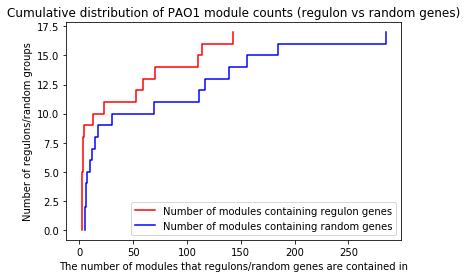

In [44]:
cumulative_distribution(
    pao1_regulon["Num_regulon_modules"],
    label="Number of modules containing regulon genes",
    color="red",
)
cumulative_distribution(
    pao1_regulon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of PAO1 module counts (regulon vs random genes)")
plt.ylabel("Number of regulons/random groups")
plt.xlabel("The number of modules that regulons/random genes are contained in")

scipy.stats.ks_2samp(
    pao1_regulon["Num_regulon_modules"], pao1_regulon["Num_random_modules"]
)

Text(0.5, 1.0, 'PMF distribution of module counts (regulon vs random genes)')

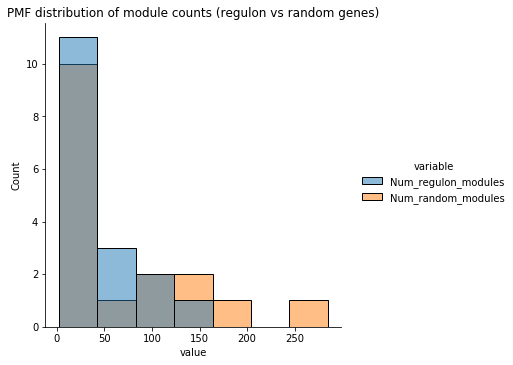

In [45]:
fig = sns.displot(
    pao1_regulon_toplot,
    x="value",
    hue="variable",
)
plt.title("PMF distribution of module counts (regulon vs random genes)")

Ks_2sampResult(statistic=0.75, pvalue=0.0009152541476018802)

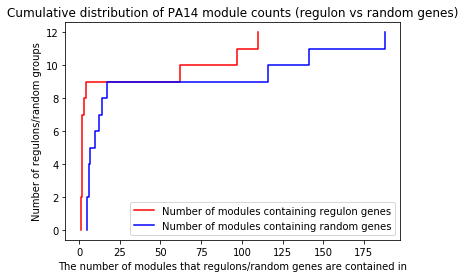

In [46]:
cumulative_distribution(
    pa14_regulon["Num_regulon_modules"],
    label="Number of modules containing regulon genes",
    color="red",
)
cumulative_distribution(
    pa14_regulon["Num_random_modules"],
    label="Number of modules containing random genes",
    color="blue",
)
_ = plt.legend()
plt.title("Cumulative distribution of PA14 module counts (regulon vs random genes)")
plt.ylabel("Number of regulons/random groups")
plt.xlabel("The number of modules that regulons/random genes are contained in")

scipy.stats.ks_2samp(
    pa14_regulon["Num_regulon_modules"], pa14_regulon["Num_random_modules"]
)

### Check what size the modules are that regulon/operon/random genes are found in

In [47]:
pao1_operon["operon_module_ids"] = pao1_operon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_operon["random_module_ids"] = pao1_operon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_operon.head()

,Length,Genes,Genes_processed,Length_processed,Random_Genes,Num_operon_modules,Num_random_modules,operon_module_ids,random_module_ids
OperonID,,,,,,,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA0001, PA0002, PA0003, PA0004]",4,"[PA2343, PA0361, PA5405, PA0117]",4,4,"[390, 0, 491, 298]","[224, 431, 427, 23]"
12030,2,"[PA0005, PA0006]","[PA0005, PA0006]",2,"[PA2343, PA0361]",2,2,"[522, 390]","[224, 431]"
12031,2,"[PA0008, PA0009]","[PA0008, PA0009]",2,"[PA2343, PA0361]",2,2,"[0, 89]","[224, 431]"
12032,3,"[PA0016, PA0017, PA0018]","[PA0016, PA0017, PA0018]",3,"[PA2343, PA0361, PA5405]",1,3,[2],"[224, 431, 427]"
12033,2,"[PA0021, PA0022]","[PA0021, PA0022]",2,"[PA2343, PA0361]",2,2,"[546, 495]","[224, 431]"


In [48]:
pao1_membership["module id"].value_counts()

562    47
304    35
178    34
72     34
457    29
62     27
159    26
547    26
481    26
9      25
203    24
503    24
380    23
230    23
54     23
415    22
443    22
317    21
332    21
188    21
99     21
337    20
202    20
183    19
535    19
522    19
22     19
379    18
158    18
421    18
       ..
311     5
500     4
520     4
119     4
475     4
187     4
48      4
208     4
524     4
235     4
189     4
315     4
217     4
194     4
518     4
13      4
348     4
106     3
282     3
499     3
521     3
66      3
38      3
146     3
483     3
16      3
358     3
470     3
122     2
548     2
Name: module id, Length: 564, dtype: int64

In [49]:
pao1_regulon["regulon_module_ids"] = pao1_regulon["Genes_processed"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_regulon["random_module_ids"] = pao1_regulon["Random_Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].unique()
)
pao1_regulon.head()

,Lengths,Genes,Genes_processed,Length_processed,Random_Genes,Num_regulon_modules,Num_random_modules,regulon_module_ids,random_module_ids
Regulon,,,,,,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",23,69,"[317, 345, 101, 199, 46, 528, 142, 141, 383, 5...","[224, 431, 427, 23, 451, 263, 303, 443, 464, 1..."
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",114,139,"[93, 193, 9, 11, 12, 136, 19, 228, 456, 287, 3...","[224, 431, 427, 23, 451, 263, 303, 443, 464, 1..."
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",2,14,"[230, 231]","[224, 431, 427, 23, 451, 263, 303, 443, 464, 1..."
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",2,12,"[413, 464]","[224, 431, 427, 23, 451, 263, 303, 443, 464, 1..."
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228,"[PA2343, PA0361, PA5405, PA0117, PA4437, PA022...",110,185,"[31, 510, 426, 5, 363, 63, 481, 16, 507, 22, 5...","[224, 431, 427, 23, 451, 263, 303, 443, 464, 1..."


_About cumulative distribution plots:_
* The axis cumulative distribution plots are:
    * y-axis = The number of operon/regulon (red) or random (blue) groups.
    * x-axis = The number of modules that operon/regulon/random genes are contained in

* Looking at the regulon plot, the value at "1" on the x-axis says that there is 1 regulon found in exactly 1 module, and there are 0 random groups found in exactly 1 module
    * Then the increase at "2" on the x-axis is the number of regulons or random genes that are spread across 2 or 1 different modules (this is the cumulative part). In other words, a random set (size matched with the operon) where the genes in that set are found in 2 modules.
    * There are 3 regulons that are found in either 1 or 2 modules. There are 2 random groups that are found in either 1 or 2 modules.
    * Then if you compare the blue and the red curves, the vertical distance between the two curves tells you how much of a shift there is between the distributions.
* These distribution plots are summing counts as you move from left to right, so a shift in the curves corresponds to a shift in the distribution (i.e. a curve shifted to the right means that the distribution is shifted to the right)

**Takeaway:**
* We can perform [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to compare the distribution of module counts for genes in regulons/operons versus random genes. The KS test will quantify the difference in the cumulative distribution curves.

* Based on the KS test, there is a significant difference (across thresholds) between the operon and random distribution, as we would expect.
    * There is only a significant difference between the regulon and random distributions. The lack of significance is likely due to the small sample size (i.e. 6 or 10 regulons have genes that are contained in modules with fewer than 1000 genes)